## Translating DBpedia queries to Wikidata with LLMs **Baseline model**

In [1]:
# import all the necessary libraries
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

In [2]:
# Load the dataset from 100_complete_entries.json
with open("../../../data/100_complete_entries.json", "r") as file:
    data = json.load(file)

# Create input dataset for the baseline model
baseline_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    dbpedia_query = entry.get("dbpedia_query", "")  # SPARQL query for DBpedia

    # Construct the input for the baseline model
    baseline_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": dbpedia_query,
            "kg1_name": "DBpedia",
            "kg2_name": "Wikidata",
            "instruction": "Given the information above, produce a SPARQL query for KG2. In your answer please highlight the final, complete SPARQL query within the tags '<sparql>' and '</sparql>'."
        }
    }
    baseline_inputs.append(baseline_input)

# Save the processed dataset to a new JSON file
with open("baseline_input_dataset.json", "w") as file:
    json.dump(baseline_inputs, file, indent=4)

print(f"Baseline dataset saved to 'baseline_input_dataset.json'.")


Baseline dataset saved to 'baseline_input_dataset.json'.


## Testing meta-llama-3.1-8b-instruct with 100 queries
The model includes 8billion parameters and is one of the samallest available models at Academic Cloud.

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("baseline_input_dataset.json", "r") as file:  # Use the baseline input dataset
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question: {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("baseline_translated_llm_output_llama.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'baseline_translated_llm_output_llama.json'.")


Error querying LLM for question: What is the alma mater of the chancellor of Germany Angela Merkel?: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': '2069a07666ee973741d50d774e58a214'}
Error querying LLM for question: Who created Goofy?: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': 'e622b934747b110c1202e37ef0b7ca41'}
Translated SPARQL queries for all questions saved to 'baseline_translated_llm_output_llama.json'.


## Testing Mistral-Large-instruct with 100 queries
The model includes 123billion parameters and is the largest available model at Academic Cloud https://chat-ai.academiccloud.de

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
input_file_path = "baseline_input_dataset.json"  # Adjust path if needed
output_file_path = "baseline_translated_llm_output_mistral.json"

with open(input_file_path, "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": {
                "natural_language_question": context["natural_language_question"],
                "sparql_query_kg1": context["sparql_query_kg1"],
                "kg1_name": context["kg1_name"],
                "kg2_name": context["kg2_name"],
                "instruction": context["instruction"]
            },
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question: {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open(output_file_path, "w") as file:
    json.dump(translated_dataset, file, indent=4)

print(f"Translated SPARQL queries for all questions saved to '{output_file_path}'.")

Translated SPARQL queries for all questions saved to 'baseline_translated_llm_output.json'.


## Analysis of the results

Extracting the SPARQL queries from LLM output for **mistral-large-instruct**

In [11]:
# Load the input JSON file
file_path = "baseline_translated_llm_output_mistral.json"
output_file = "baseline_mistral_wiki_trans_sparql_queries.json"

with open(file_path, "r") as file:
    data = json.load(file)

# Function to extract SPARQL query from the `sparql_query_kg2` field and remove comments
def extract_sparql_query(entry):
    raw_query = entry.get("sparql_query_kg2", "")

    # Remove comments starting with `#` and clean up spaces
    cleaned_query = re.sub(r"#.*", "", raw_query)  # Remove everything after `#` on each line

    # Try extracting query from <sparql>...</sparql> tags
    match = re.search(r"<sparql>(.*?)</sparql>", cleaned_query, re.DOTALL)
    if not match:
        # Try extracting content between SPARQL code blocks (```sparql ... ```)
        match = re.search(r"```sparql\s*(.*?)\s*```", cleaned_query, re.DOTALL)

    if match:
        query = match.group(1).replace("\n", " ").strip()  # Remove newline characters and trim whitespace
        return query

    # If no structured query is found, try extracting a raw SELECT statement
    match = re.search(r"(SELECT.*?WHERE\s*\{.*?\})", cleaned_query, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).replace("\n", " ").strip()

    return None

# Extract SPARQL queries with natural language questions
queries_with_context = []
for entry in data:
    sparql_query = extract_sparql_query(entry)
    context = entry.get("context", {})
    question = context.get("natural_language_question", "Unknown Question")
    
    if sparql_query:
        queries_with_context.append({
            "natural_language_question": question,
            "sparql_query_kg2": sparql_query
        })

# Save the extracted queries to a new JSON file
with open(output_file, "w") as file:
    json.dump(queries_with_context, file, indent=4)

print(f"Cleaned and extracted SPARQL queries saved to {output_file}.")
print(f"Total extracted queries: {len(queries_with_context)} out of {len(data)}")


Cleaned and extracted SPARQL queries saved to baseline_mistral_wiki_trans_sparql_queries.json.
Total extracted queries: 100 out of 100


In [24]:
# Load the input JSON file
file_path = "baseline_translated_llm_output_mistral.json"
output_file = "baseline_mistral_wiki_trans_sparql_queries.json"
failed_output_file = "failed_sparql_queries_mistral.json"

with open(file_path, "r") as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_sparql_query(entry):
    raw_query = entry.get("sparql_query_kg2", "")

    # Remove comments starting with `#` and clean up spaces
    cleaned_query = re.sub(r"#.*", "", raw_query)  # Remove everything after `#` on each line

    # Try extracting query from <sparql>...</sparql> tags
    match = re.search(r"<sparql>(.*?)</sparql>", cleaned_query, re.DOTALL)
    if not match:
        # Try extracting content between SPARQL code blocks (```sparql ... ```)
        match = re.search(r"```sparql\s*(.*?)\s*```", cleaned_query, re.DOTALL)

    if match:
        query = match.group(1).replace("\n", " ").strip()  # Remove newline characters and trim whitespace
        return query

    # If no structured query is found, try extracting a raw SELECT statement
    match = re.search(r"(SELECT.*?WHERE\s*\{.*?\})", cleaned_query, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).replace("\n", " ").strip()

    return None

# Extract SPARQL queries with natural language questions
queries_with_context = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

for entry in data:
    sparql_query = extract_sparql_query(entry)
    context = entry.get("context", {})
    question = context.get("natural_language_question", "Unknown Question")
    
    if sparql_query:
        queries_with_context.append({
            "natural_language_question": question,
            "sparql_query_kg2": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": question,
            "sparql_query_raw": entry.get("sparql_query_kg2", "")
        })

# Save the extracted queries to a new JSON file
with open(output_file, "w") as file:
    json.dump(queries_with_context, file, indent=4)

# Save failed extractions for debugging
with open(failed_output_file, "w") as failed_file:
    json.dump(failed_queries, failed_file, indent=4)

# Print statistics
print(f"Cleaned and extracted SPARQL queries saved to {output_file}.")
print(f"Failed queries saved to {failed_output_file}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed extractions: {total_entries - extracted_count}")
print(f"Extraction success rate: {extracted_count / total_entries * 100:.2f}%")


Cleaned and extracted SPARQL queries saved to baseline_mistral_wiki_trans_sparql_queries.json.
Failed queries saved to failed_sparql_queries_mistral.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed extractions: 0
Extraction success rate: 100.00%


Extracting the SPARQL queries from LLM output for **lama-3.1-8b-instruct**.

In [36]:
input_file_path = 'baseline_translated_llm_output_llama.json'
output_file_path = 'baseline_llama_wiki_trans_sparql_queries.json'
failed_output_file_path = 'failed_sparql_queries_llama.json'

# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_and_clean_sparql_query(sparql_raw):
    try:
        # Match SPARQL code blocks or queries starting with PREFIX
        sparql_match = re.search(r"<sparql>(.*?)</sparql>|```sparql\s*(.*?)\s*```|PREFIX.*?WHERE\s*\{.*?\}", sparql_raw, re.DOTALL)
        if sparql_match:
            # Extract the matched SPARQL query (using the first non-None match)
            query = sparql_match.group(1) or sparql_match.group(2) or sparql_match.group(0)
            # Clean query by removing comments and excessive whitespace
            query = re.sub(r"#.*", "", query)  # Remove comments
            query = re.sub(r"\s+", " ", query).strip()  # Remove excessive whitespace and newlines
            query = query.replace("```sparql", "").replace("```", "").strip()  # Remove markers
            return query
    except Exception as e:
        print(f"Error cleaning SPARQL query: {e}")
    return None

# Process all entries and keep natural language question with the query
result = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

for entry in data:
    context = entry.get('context', {})
    natural_language_question = context.get('natural_language_question', None)
    sparql_query_raw = entry.get('sparql_query_kg2', '')

    # Extract and clean the SPARQL query
    sparql_query = extract_and_clean_sparql_query(sparql_query_raw)

    if natural_language_question and sparql_query:
        result.append({
            "natural_language_question": natural_language_question,
            "sparql_query": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": sparql_query_raw
        })

# Save the successfully extracted queries to a new JSON file
with open(output_file_path, 'w') as output_file:
    json.dump(result, output_file, indent=4)

# Save the failed extractions for debugging
with open(failed_output_file_path, 'w') as failed_file:
    json.dump(failed_queries, failed_file, indent=4)

print(f"Cleaned and extracted data has been saved to {output_file_path}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed extractions saved to {failed_output_file_path}")
print(f"Extraction success rate: {extracted_count / total_entries * 100:.2f}%")


Cleaned and extracted data has been saved to baseline_llama_wiki_trans_sparql_queries.json.
Total entries processed: 98
Successfully extracted queries: 94
Failed extractions saved to failed_sparql_queries_llama.json
Extraction success rate: 95.92%


## Run the extracted SPARQL queries on Wikidata
Results for **mistral-large-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"[\\": mismatched input \'[\' expecting \'}\'",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 141,\n        "query": "PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX wd: <http://www.wikidata.org/entity/>  SELECT ?uri WHERE {   ?uri wdt:P31 wdt:P136 [ wdt:P175 wd:Q283233 ] .   FILTER(BOUND(?uri)) }",\n        "startIndex": 141,\n        "stopIndex": 141\n    },\n    "query": "PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX wd: <http://www.wikidata.org/entity/>  SELECT ?uri WHERE {   ?uri wdt:P31 wdt:P136 [ wdt:P175 wd:Q283233 ] .   FILTER(BOUND(?uri)) }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 1,\n        "total": 1\n    }\n}'
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL 

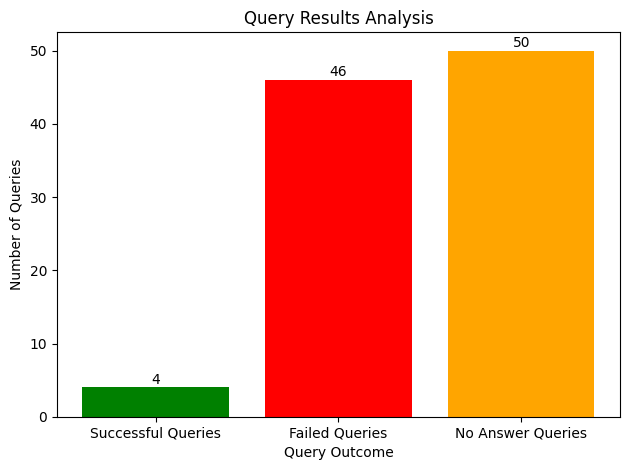

In [25]:
# File paths
input_file_path = "baseline_mistral_wiki_trans_sparql_queries.json"
output_file_path = "baseline_wikidata_query_results_mistral.json"

# Wikidata local endpoint
WIKIDATA_ENDPOINT = "http://localhost:7001"

# Define prefixes for the queries
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the Wikidata endpoint
    results = query_sparql(WIKIDATA_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **lama-3.1-8b-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Prefix wkt was not registered using a PREFIX declaration",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 177,\n        "query": "PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX wd: <http://www.wikidata.org/entity/> SELECT DISTINCT ?uri WHERE { ?uri wdt:P31 wd:Q11424. ?uri wdt:P57 wd:Q328. BIND (wkt:label(?uri) AS ?title) }",\n        "startIndex": 177,\n        "stopIndex": 185\n    },\n    "query": "PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX wd: <http://www.wikidata.org/entity/> SELECT DISTINCT ?uri WHERE { ?uri wdt:P31 wd:Q11424. ?uri wdt:P57 wd:Q328. BIND (wkt:label(?uri) AS ?title) }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 1,\n        "total": 1\n    }\n}'
Query failed: QueryBadFormed: A bad request has been sent to t

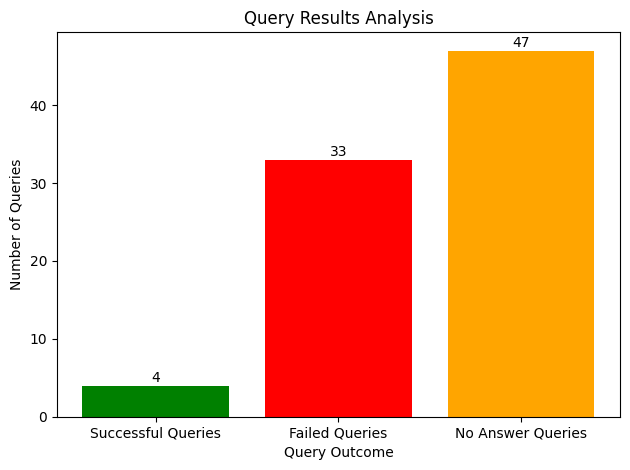

In [26]:
# File paths
input_file_path = "baseline_llama_wiki_trans_sparql_queries.json"
output_file_path = "baseline_wikidata_query_results_llama.json"

# Wikidata local endpoint
WIKIDATA_ENDPOINT = "http://localhost:7001"

# Define prefixes for the queries
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the Wikidata endpoint
    results = query_sparql(WIKIDATA_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()


## Comparison of wikidata output with original output
In the following the final output of querying Wikidata is compared to the original output of querying QALD9-Plus dataset.

### Comparison lama-3.1-8b-instruct_template with original output

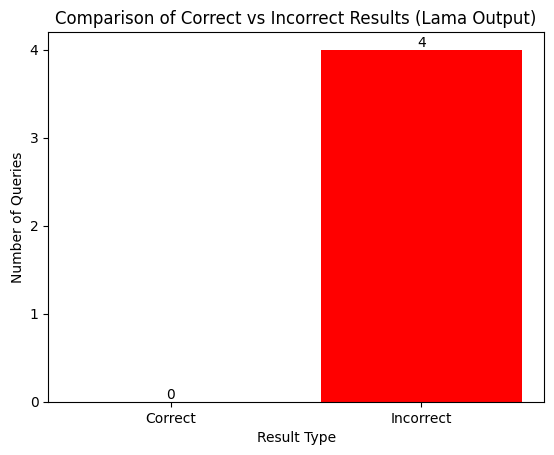

Comparison completed. Results saved to 'baseline_comparison_results_llama.xlsx'.


In [34]:
# Define the file paths
solution_file_path = os.path.join("../../data/100_complete_entries_solution.json")
lama_output_file_path = "baseline_wikidata_query_results_llama.json"

# Load the datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['wikidata_results'] for entry in solution_data}

# Compare answers
for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Skip entries with "Query failed" or "No answer"
    if "Query failed" in lama_answers or "No answer" in lama_answers:
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })

# Save the results to an Excel file for review
results_df = pd.DataFrame(comparison_results)
results_df.to_excel("baseline_comparison_results_llama.xlsx", index=False)

# Create a bar chart of correct vs. incorrect results
correct_count = results_df['is_correct'].sum()
incorrect_count = len(results_df) - correct_count

# Bar chart with custom colors and annotations
colors = ['green', 'red']
counts = [correct_count, incorrect_count]
labels = ['Correct', 'Incorrect']

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=colors)

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Configure y-axis to show only integer values
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add title and labels
plt.title('Comparison of Correct vs Incorrect Results (Lama Output)')
plt.xlabel('Result Type')
plt.ylabel('Number of Queries')
plt.show()

print("Comparison completed. Results saved to 'baseline_comparison_results_llama.xlsx'.")

### Comparison mistral-large-instruct with original output

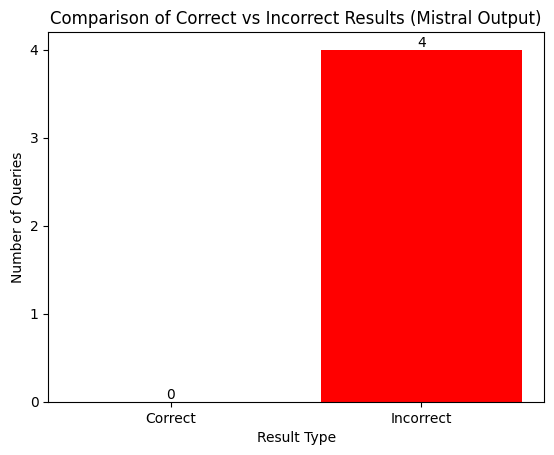

Comparison completed. Results saved to 'baseline_comparison_results_mistral.xlsx'.


In [35]:
# Define the file paths
solution_file_path = os.path.join("../../data/100_complete_entries_solution.json")
mistral_output_file_path = "baseline_wikidata_query_results_mistral.json"

# Load the datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r') as f:
    mistral_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['wikidata_results'] for entry in solution_data}

# Compare answers
for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question")
    mistral_answers = mistral_entry.get("answers", [])

    # Skip entries with "Query failed" or "No answer"
    if "Query failed" in mistral_answers or "No answer" in mistral_answers:
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(mistral_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "mistral_answers": mistral_answers,
            "is_correct": is_correct
        })

# Save the results to an Excel file for review
results_df = pd.DataFrame(comparison_results)
results_df.to_excel("baseline_comparison_results_mistral.xlsx", index=False)

# Create a bar chart of correct vs. incorrect results
correct_count = results_df['is_correct'].sum()
incorrect_count = len(results_df) - correct_count

# Bar chart with custom colors and annotations
colors = ['green', 'red']
counts = [correct_count, incorrect_count]
labels = ['Correct', 'Incorrect']

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=colors)

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Configure y-axis to show only integer values
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add title and labels
plt.title('Comparison of Correct vs Incorrect Results (Mistral Output)')
plt.xlabel('Result Type')
plt.ylabel('Number of Queries')
plt.show()

print("Comparison completed. Results saved to 'baseline_comparison_results_mistral.xlsx'.")


## Thoughts on the results
The results are highly unsatisfactory. Out of 100 queries, only four return any results. Notably, different answers are produced when comparing the outputs of LLaMA and Mistral. While most queries do not yield any results despite being executable, a significant number are syntactically incorrect and cannot be executed at all. Among the four queries that do produce results, all contain incorrect answers. For instance, in response to the question "What is the capital of Canada?", the returned answer is http://www.wikidata.org/entity/Q61 (Washington D.C.), whereas the correct answer should be http://www.wikidata.org/entity/Q1930 (Ottawa).